In [1]:
from __future__ import print_function

import lasagne
import numpy as np
import pandas as pd
import _pickle as pickle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

### Load trained network params

In [4]:
npz_file =  "../model-mlp_n100-e100.txt.npz"

In [5]:
# Load network params
with np.load(npz_file) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

### Inspect params

In [6]:
print_statement = "Number of params: %s" % len(param_values)
print(print_statement)
print("="*len(print_statement))

for i in param_values:
    print(i.shape)

Number of params: 4
(784, 100)
(100,)
(100, 10)
(10,)


- weights for input to hidden layer
- bias to hidden layer
- weights for hidden to output layer
- bias to output layer

In [7]:
# save to variable
w_l1 = pd.DataFrame(param_values[0])
w_l2 = pd.DataFrame(param_values[2])

In [8]:
w_l1.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.014479,0.029009,0.046930,-0.068767,-0.072955,-0.056936,0.037413,-0.035617,-0.006154,-0.012323,...,-0.000928,0.013216,0.070990,-0.068386,0.060031,0.033323,0.049020,-0.044059,-0.004122,-0.068930
1,-0.028880,0.032891,-0.013243,0.022176,-0.078049,0.027832,0.032522,0.081110,0.054860,-0.004697,...,0.067200,0.032142,0.070008,-0.040007,-0.053996,0.064378,-0.056924,0.026438,0.026132,0.035927
2,-0.029655,-0.050085,0.052168,0.075324,-0.021551,0.050779,0.037255,-0.003851,-0.039800,0.080876,...,0.071727,-0.070025,-0.014294,0.058745,0.046409,-0.032020,-0.031919,0.039770,0.015537,-0.046724
3,-0.008251,-0.017018,0.032789,0.012003,0.030995,0.019618,-0.008866,-0.006040,-0.012399,-0.000843,...,-0.064733,0.042256,0.033383,0.075172,-0.075674,-0.003351,0.067799,0.050744,-0.081283,-0.059235
4,0.057540,0.009374,0.053935,-0.020876,-0.049427,-0.002678,-0.039903,-0.069109,-0.001095,-0.070636,...,0.001533,0.024731,-0.064645,0.057264,-0.038429,-0.035402,-0.027297,0.041769,0.060420,-0.072573


In [9]:
w_l2.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.268771,0.168384,0.230999,-0.051672,-0.197463,-0.159430,-0.262257,0.179053,-0.196706,0.011686
1,0.149406,-0.291997,-0.149943,0.025561,0.269654,-0.000337,0.208249,0.276273,-0.257850,0.217936
2,-0.199888,0.045097,0.105367,-0.198538,0.080166,-0.220599,-0.228191,0.152751,0.160011,0.215469
3,0.279600,0.051023,0.187129,0.246967,0.020880,-0.121254,-0.023401,-0.069478,0.176130,-0.219162
4,-0.020310,-0.069427,-0.127581,-0.079308,-0.036943,-0.283743,0.229177,-0.207398,-0.204034,0.063006


Quick visual of weights

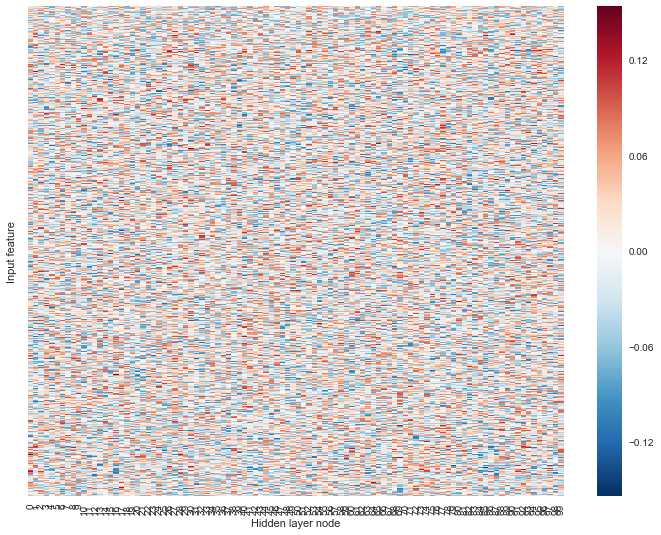

In [10]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(w_l1, yticklabels="")
plt.ylabel("Input feature")
plt.xlabel("Hidden layer node")

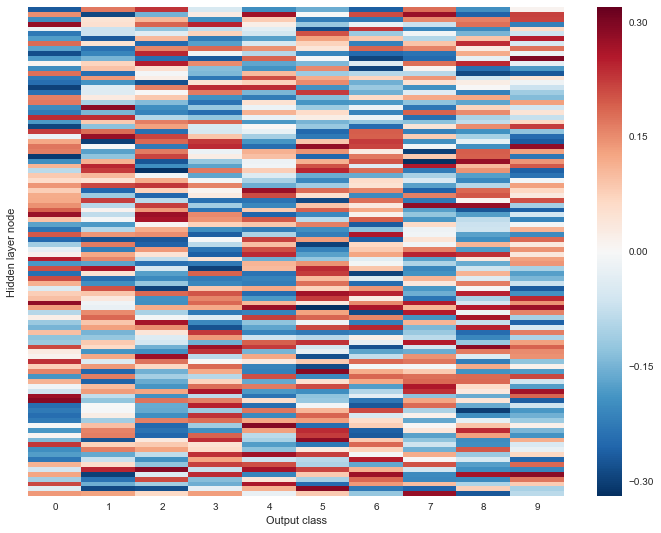

In [11]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(w_l2, yticklabels="")
plt.xlabel("Output class")
plt.ylabel("Hidden layer node")

/Users/csiu/software/anaconda/anaconda2-4.0.0/envs/kaggle/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


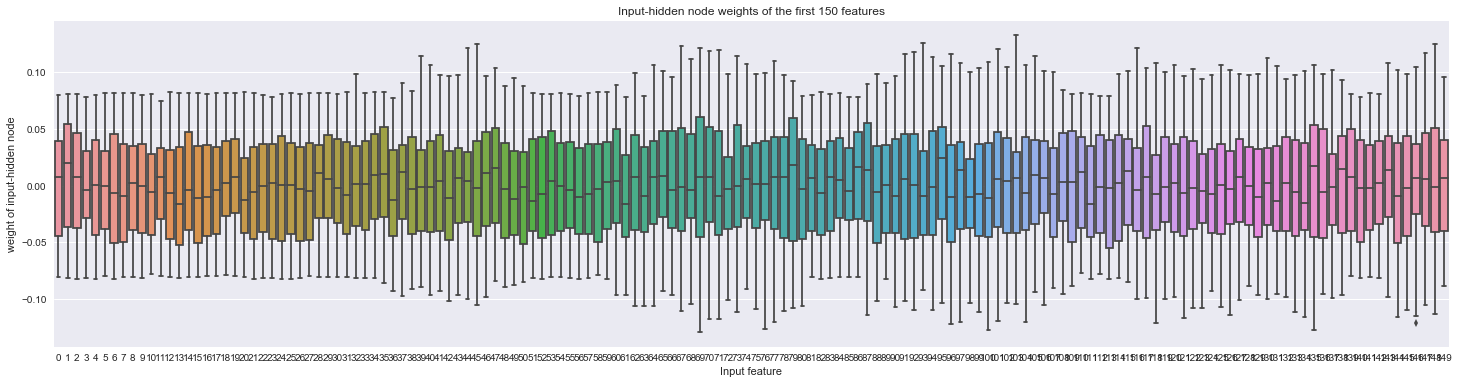

In [12]:
n = 150

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(w_l1[:n].transpose())
plt.xlabel("Input feature")
plt.ylabel("weight of input-hidden node")
plt.title("Input-hidden node weights of the first {} features".format(n))

Weight of some regions are more variable than others

### Garson's algorithm

In [13]:
def garson(A, B):
    """
    Computes Garson's algorithm
    A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
    B = vector of weights of hidden-output layer
    """
    B = np.diag(B)

    # connection weight through the different hidden node
    cw = np.dot(A, B)

    # weight through node (axis=0 is column; sum per input feature)
    cw_h = abs(cw).sum(axis=0)

    # relative contribution of input neuron to outgoing signal of each hidden neuron
    # sum to find relative contribution of input neuron
    rc = np.divide(abs(cw), abs(cw_h))
    rc = rc.sum(axis=1)

    # normalize to 100% for relative importance
    ri = rc / rc.sum()
    return(ri)

In [14]:
# Run Garson's algorithm
df = {}
for i in range(w_l2.shape[1]):
    df[i] = garson(w_l1, w_l2[i])

# Reformat
df = pd.DataFrame(df)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269,0.001269
1,0.001354,0.001354,0.001354,0.001354,0.001354,0.001354,0.001354,0.001354,0.001354,0.001354
2,0.001304,0.001304,0.001304,0.001304,0.001304,0.001304,0.001304,0.001304,0.001304,0.001304
3,0.001083,0.001083,0.001083,0.001083,0.001083,0.001083,0.001083,0.001083,0.001083,0.001083
4,0.001193,0.001193,0.001193,0.001193,0.001193,0.001193,0.001193,0.001193,0.001193,0.001193


- Feature importance looks the save across the different output classes

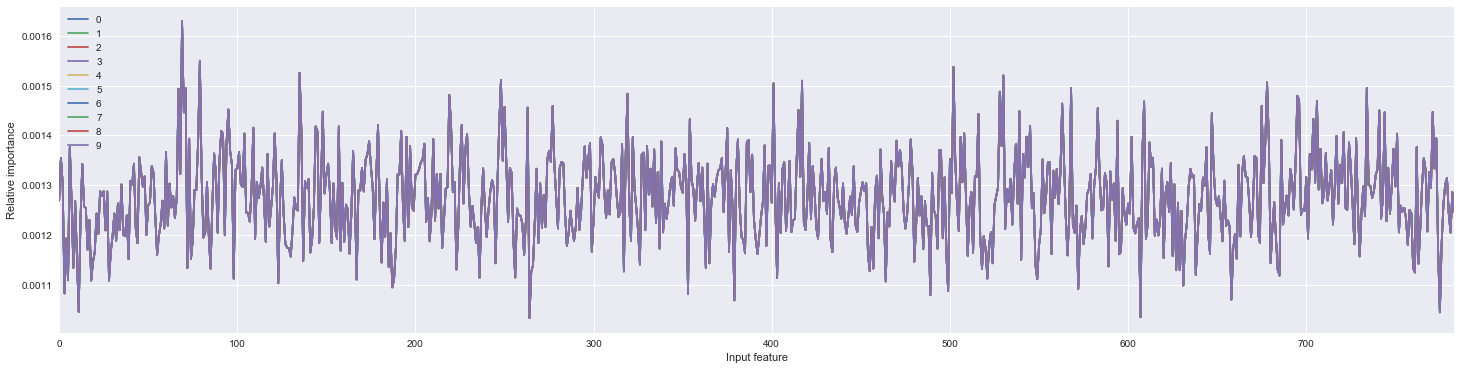

In [15]:
f, ax = plt.subplots(figsize=(25, 6))
df.plot(kind="line", ax=ax)
plt.xlabel("Input feature")
plt.ylabel("Relative importance")

- Indeed looks the same; seems like classification of feature importance does not depend on output class

In [16]:
## Index of top 10 feature & their relative imo
df_ri = pd.DataFrame(df[0], columns=["relative_importance"]).sort_values(by="relative_importance", ascending=False)
df_ri.head(10)

,relative_importance
69,0.001629
79,0.001550
502,0.001537
135,0.001526
530,0.001520
248,0.001511
417,0.001510
678,0.001506
401,0.001504
734,0.001495
